# Exploration 4

In [198]:
! pip install --upgrade statsmodels==0.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [199]:
import pandas as pd
import sklearn
import statsmodels

print(pd.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.5
1.0.2
0.13.0


# 1. 시계열 데이터 준비

In [200]:
samsung_path = '/content/samsung.csv'
df = pd.read_csv(samsung_path)
df.head

<bound method NDFrame.head of            Date     Open     High      Low    Close     Adj Close    Volume
0    2021-07-26  79400.0  79500.0  78800.0  78800.0  77673.101563  10040975
1    2021-07-27  79200.0  79400.0  78500.0  78500.0  77377.390625  11427693
2    2021-07-28  78300.0  79200.0  78100.0  79200.0  78067.382813  12743417
3    2021-07-29  78800.0  79400.0  78800.0  79000.0  77870.242188  14360453
4    2021-07-30  78900.0  78900.0  78500.0  78500.0  77377.390625  13823411
..          ...      ...      ...      ...      ...           ...       ...
239  2022-07-19  61400.0  61500.0  60200.0  60900.0  60900.000000  15248261
240  2022-07-20  61800.0  62100.0  60500.0  60500.0  60500.000000  16782238
241  2022-07-21  61100.0  61900.0  60700.0  61800.0  61800.000000  12291374
242  2022-07-22  61800.0  62200.0  61200.0  61300.0  61300.000000  10261310
243  2022-07-25  60900.0  61900.0  60800.0  61300.0  61300.000000   7666824

[244 rows x 7 columns]>

column =  'Date', 'Open', 'High', 'Low','Close', 'Adj Close', 'Volume'

날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있다.

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Time Series 생성
samsung_path = '/content/samsung.csv'
df = pd.read_csv(samsung_path, index_col = 'Date', parse_dates=True) # 종가 기준으로
ts = df['Close']


ts.head()

Date
2021-07-26    78800.0
2021-07-27    78500.0
2021-07-28    79200.0
2021-07-29    79000.0
2021-07-30    78500.0
Name: Close, dtype: float64

# 2. 각종 전처리 수행

In [202]:
# 결측치 처리

ts = ts.interpolate(method = 'time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [203]:
# 로그 변환 why ? 값 편향성을 없애려고

ts_log = np.log(ts)

# 3. 시계열 안정성 분석

In [204]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [205]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

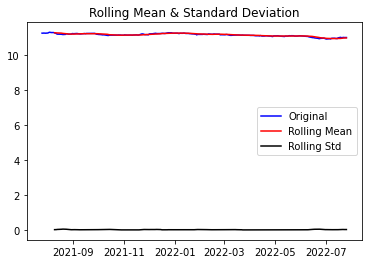

Results of Dickey-Fuller Test:
Test Statistic                  -0.967314
p-value                          0.764998
#Lags Used                       0.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


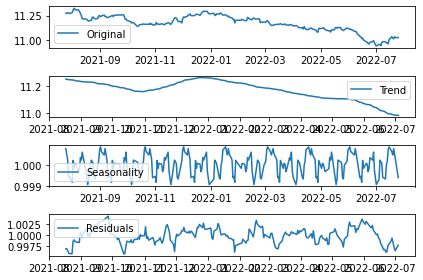

In [206]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [207]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.999901
p-value                          0.000022
#Lags Used                       1.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


# 4. 학습, 테스트 데이터셋 생성

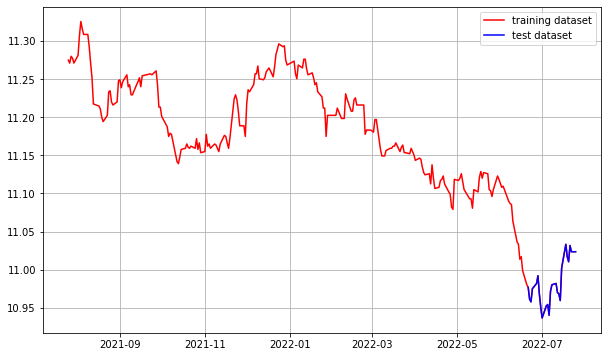

In [208]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 5. 적정 ARIMA 모수 찾기

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


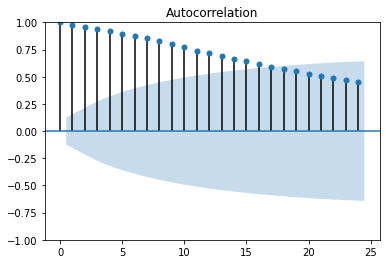

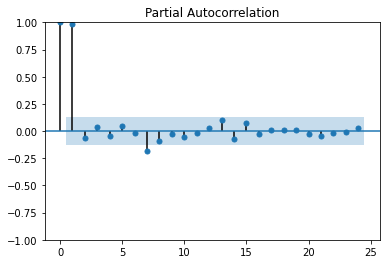

In [209]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 6. ARIMA 모델 훈련과 테스트

In [210]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  219
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 633.778
Date:                Mon, 25 Jul 2022   AIC                          -1257.557
Time:                        09:48:35   BIC                          -1240.612
Sample:                             0   HQIC                         -1250.713
                                - 219                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1878      0.174     64.315      0.000      10.847      11.529
ar.L1          0.7635      0.862      0.886      0.376      -0.925       2.452
ar.L2          0.2305      0.859      0.268      0.7

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


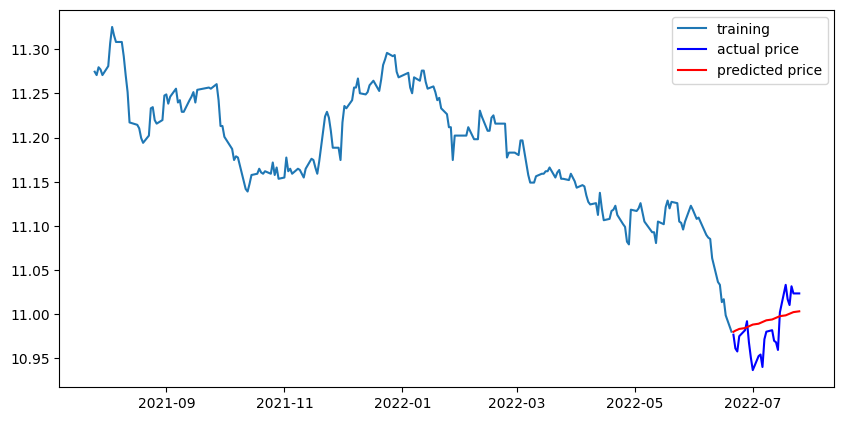

In [211]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [212]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2421871.1015949296
MAE:  1338.5404884577974
RMSE:  1556.2361972383658
MAPE: 2.30%


# 7. 다른 주식 종목 예측해 보기

# 테슬라

In [213]:
tsla_path = '/content/TSLA.csv'
df = pd.read_csv(tsla_path)
df.head

<bound method NDFrame.head of            Date        Open        High         Low       Close   Adj Close  \
0    2021-07-26  650.969971  668.200012  647.109985  657.619995  657.619995   
1    2021-07-27  663.400024  666.500000  627.239990  644.780029  644.780029   
2    2021-07-28  647.000000  654.969971  639.400024  646.979980  646.979980   
3    2021-07-29  649.789978  683.690002  648.799988  677.349976  677.349976   
4    2021-07-30  671.760010  697.530029  669.000000  687.200012  687.200012   
..          ...         ...         ...         ...         ...         ...   
246  2022-07-18  734.809998  751.549988  718.809998  721.640015  721.640015   
247  2022-07-19  735.000000  741.419983  710.929993  736.590027  736.590027   
248  2022-07-20  740.349976  751.989990  730.450012  742.500000  742.500000   
249  2022-07-21  765.320007  819.799988  764.599976  815.119995  815.119995   
250  2022-07-22  828.659973  842.359985  812.140015  816.729980  816.729980   

       Volume  
0    

In [214]:
# Time Series 생성
tsla_path = '/content/TSLA.csv'
df = pd.read_csv(tsla_path, index_col = 'Date', parse_dates=True) # 종가 기준으로
ts = df['Close']

ts.head()

Date
2021-07-26    657.619995
2021-07-27    644.780029
2021-07-28    646.979980
2021-07-29    677.349976
2021-07-30    687.200012
Name: Close, dtype: float64

In [215]:
# 결측치 처리

ts = ts.interpolate(method = 'time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [216]:
# 로그 변환 why ? 값 편향성을 없애려고

ts_log = np.log(ts)

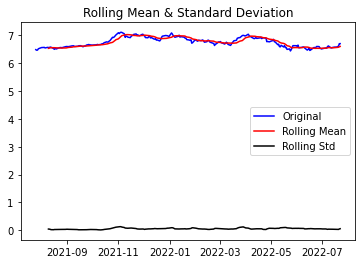

Results of Dickey-Fuller Test:
Test Statistic                  -1.903388
p-value                          0.330469
#Lags Used                      10.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


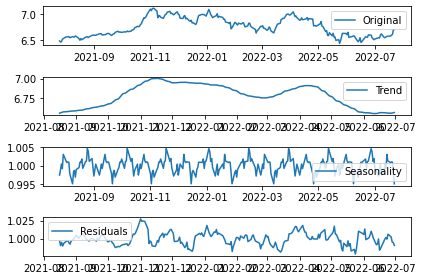

In [217]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [218]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.495261
p-value                          0.000002
#Lags Used                       9.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


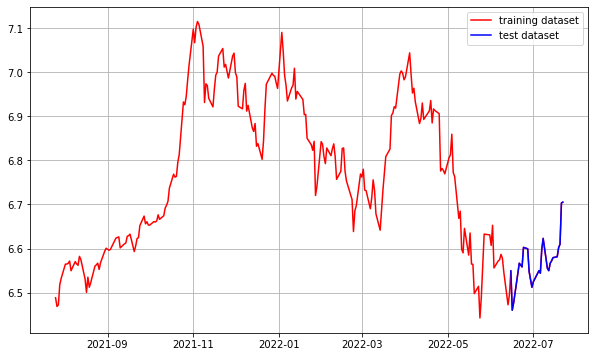

In [219]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


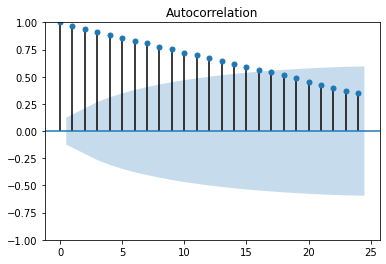

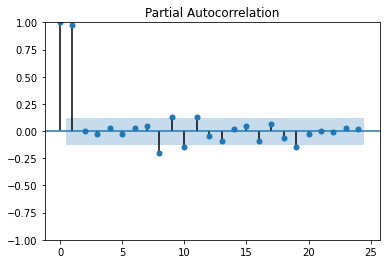

In [220]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [221]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 408.613
Date:                Mon, 25 Jul 2022   AIC                           -807.227
Time:                        09:48:38   BIC                           -790.146
Sample:                             0   HQIC                          -800.333
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6958      0.116     57.927      0.000       6.469       6.922
ar.L1          0.0803      0.109      0.734      0.463      -0.134       0.295
ar.L2          0.8780      0.106      8.270      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


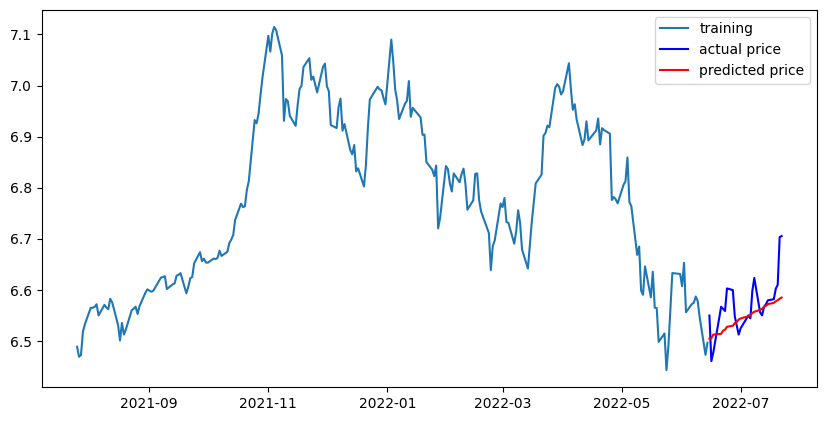

In [222]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [223]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1256.5763285936393
MAE:  25.441882225204324
RMSE:  35.44822038683521
MAPE: 3.45%


# 애플

In [224]:
apple_path = '/content/AAPL.csv'
df = pd.read_csv(apple_path)
df.head

<bound method NDFrame.head of            Date        Open        High         Low       Close   Adj Close  \
0    2021-07-26  148.270004  149.830002  147.699997  148.990005  148.143616   
1    2021-07-27  149.119995  149.210007  145.550003  146.770004  145.936234   
2    2021-07-28  144.809998  146.970001  142.539993  144.979996  144.156403   
3    2021-07-29  144.690002  146.550003  144.580002  145.639999  144.812653   
4    2021-07-30  144.380005  146.330002  144.110001  145.860001  145.031403   
..          ...         ...         ...         ...         ...         ...   
246  2022-07-18  150.740005  151.570007  146.699997  147.070007  147.070007   
247  2022-07-19  147.919998  151.229996  146.910004  151.000000  151.000000   
248  2022-07-20  151.119995  153.720001  150.369995  153.039993  153.039993   
249  2022-07-21  154.500000  155.570007  151.940002  155.350006  155.350006   
250  2022-07-22  155.389999  156.279999  153.410004  154.089996  154.089996   

        Volume  
0   

In [225]:
# Time Series 생성

apple_path = '/content/AAPL.csv'
df = pd.read_csv(apple_path, index_col = 'Date', parse_dates=True) # 종가 기준으로
ts = df['Close']

ts.head()

Date
2021-07-26    148.990005
2021-07-27    146.770004
2021-07-28    144.979996
2021-07-29    145.639999
2021-07-30    145.860001
Name: Close, dtype: float64

In [226]:
# 결측치 처리

ts = ts.interpolate(method = 'time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [227]:
# 로그 변환 why ? 값 편향성을 없애려고

ts_log = np.log(ts)

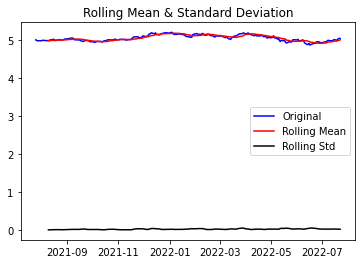

Results of Dickey-Fuller Test:
Test Statistic                  -1.911841
p-value                          0.326512
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


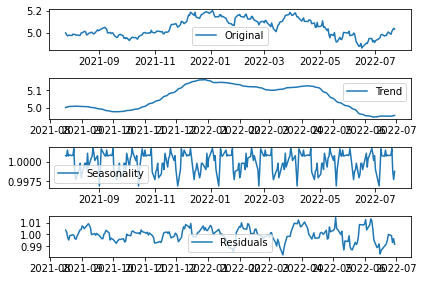

In [228]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [229]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.709119
p-value                          0.000081
#Lags Used                       9.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


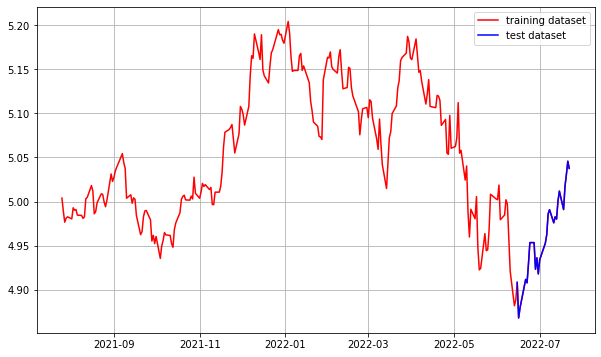

In [230]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


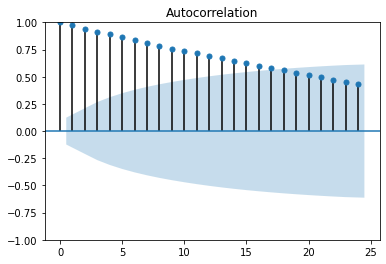

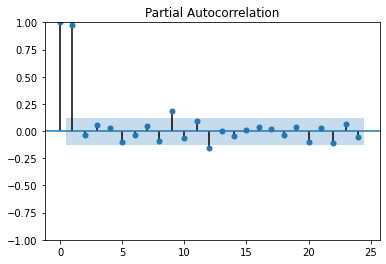

In [231]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [232]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 575.319
Date:                Mon, 25 Jul 2022   AIC                          -1140.638
Time:                        09:48:42   BIC                          -1123.557
Sample:                             0   HQIC                         -1133.744
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0662      0.069     73.733      0.000       4.932       5.201
ar.L1          0.1059      0.108      0.979      0.327      -0.106       0.318
ar.L2          0.8604      0.114      7.523      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


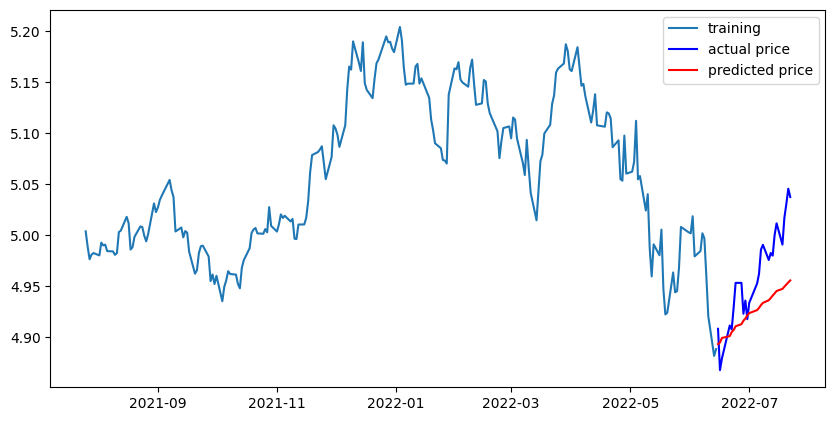

In [233]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [234]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  43.743440701711386
MAE:  5.490519431930036
RMSE:  6.613882422731098
MAPE: 3.74%


# 닌텐도

In [235]:
nintendo_path = '/content/NTDOY.csv'
df = pd.read_csv(nintendo_path)
df.head

<bound method NDFrame.head of            Date       Open       High        Low      Close  Adj Close  Volume
0    2021-07-26  68.000000  68.330002  67.650002  67.989998  67.989998  573500
1    2021-07-27  68.199997  68.919998  67.300003  67.889999  67.889999  410100
2    2021-07-28  67.250000  67.849998  67.010002  67.849998  67.849998  416200
3    2021-07-29  67.250000  67.250000  66.510002  66.559998  66.559998  487500
4    2021-07-30  64.500000  64.610001  64.010002  64.250000  64.250000  502300
..          ...        ...        ...        ...        ...        ...     ...
246  2022-07-18  56.000000  56.709999  55.910000  56.349998  56.349998  355100
247  2022-07-19  55.990002  55.990002  54.930000  55.279999  55.279999  155100
248  2022-07-20  55.500000  56.730000  55.500000  56.060001  56.060001  201200
249  2022-07-21  56.200001  56.200001  55.599998  56.000000  56.000000  161000
250  2022-07-22  56.250000  56.669998  56.049999  56.160000  56.160000  143900

[251 rows x 7 columns

In [236]:
# Time Series 생성
nintendo_path = '/content/NTDOY.csv'
df = pd.read_csv(nintendo_path, index_col = 'Date', parse_dates=True) # 종가 기준으로
ts = df['Close']

ts.head()

Date
2021-07-26    67.989998
2021-07-27    67.889999
2021-07-28    67.849998
2021-07-29    66.559998
2021-07-30    64.250000
Name: Close, dtype: float64

In [237]:
# 결측치 처리

ts = ts.interpolate(method = 'time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [238]:
# 로그 변환 why ? 값 편향성을 없애려고

ts_log = np.log(ts)

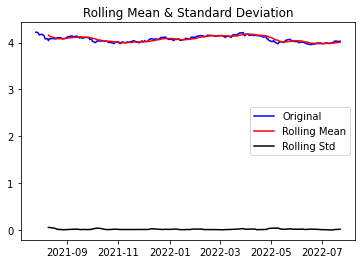

Results of Dickey-Fuller Test:
Test Statistic                  -2.539927
p-value                          0.106059
#Lags Used                       2.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


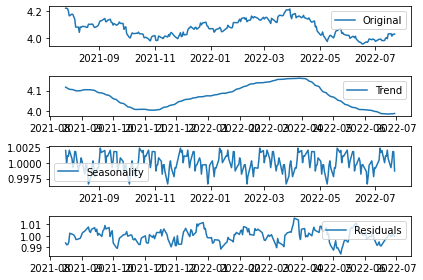

In [239]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [240]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.297703
p-value                          0.000006
#Lags Used                       0.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


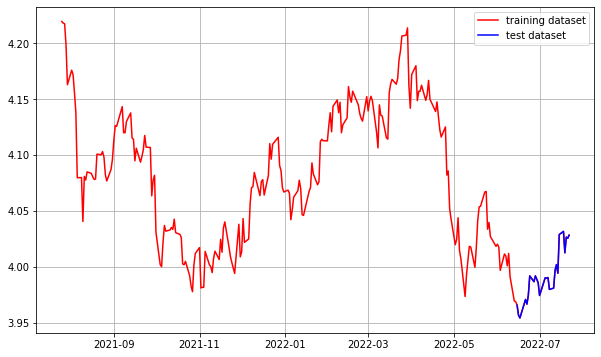

In [241]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

Results of Dickey-Fuller Test:
Test Statistic                -1.220950e+01
p-value                        1.172607e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.971813e+00
p-value                        2.768339e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


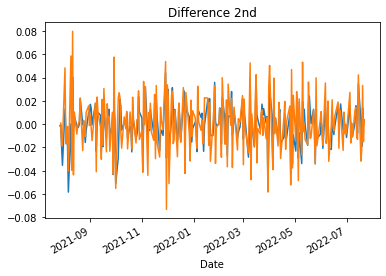

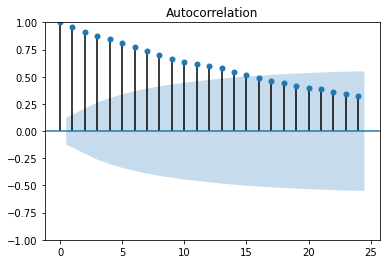

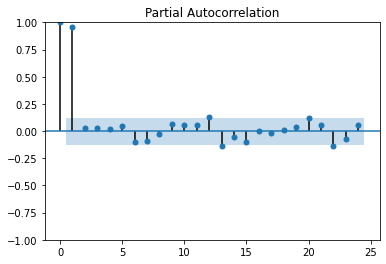

In [242]:
# 차분 안정성 확인 -> d 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [243]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 156.965
Date:                Mon, 25 Jul 2022   AIC                           -303.930
Time:                        09:48:50   BIC                           -286.850
Sample:                             0   HQIC                          -297.036
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0821      0.142     28.829      0.000       3.805       4.360
ar.L1          0.0027      0.005      0.493      0.622      -0.008       0.013
ar.L2          0.9973      0.005    185.094      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


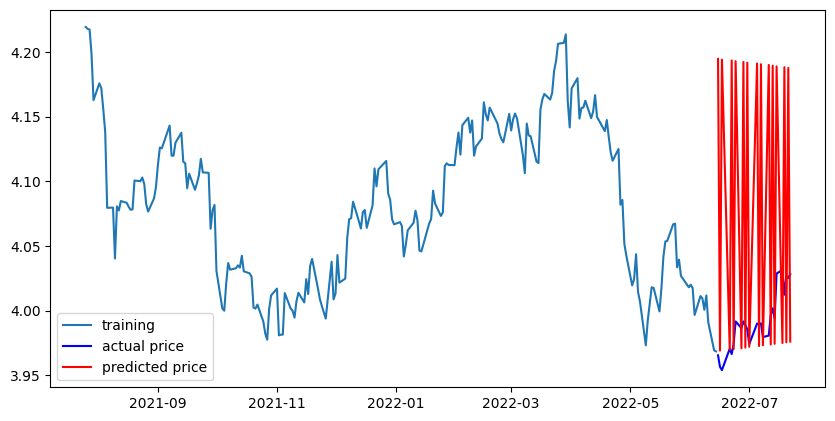

In [244]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [245]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  73.6544625391237
MAE:  6.56321086963081
RMSE:  8.582217810049084
MAPE: 12.13%


# 회고

이번 노드 너무 어렵습니다. 통계 내용을 한 번에 머리에 넣을려고 하다보니 과부하가 걸렸습니다. 그래도 차근차근 하나씩 따라하다 보니 원하는 값을 얻을 수 있었습니다. 

그래도 닌텐도 저 그래프는 왜 그런 지 아직도 의문입니다. MAPE 값이 15미만으로 나와서 망정이지 아니였으면 저번 노드처럼 고생할 뻔 했습니다. 이번에는 결과제출 할 수 있는 것만으로 위안을 삼으려고 합니다.

주제 자체가 흥미로웠습니다. 주식을 예상해보다니... 당연히 못한다는 생각이 지배적이었지만, 혹시나 하는 마음으로 했습니다. 시각화도 해보고, 예측률도 측정해보고 재밌는 실험이었습니다.